# Differentiable Boolean Satisfiability

Differentiable implementation of the [Boolean Satisfiability Problem](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem), encoded in [Conjunctive Normal Form](https://en.wikipedia.org/wiki/Conjunctive_normal_form).

$True$ is encoded as floating point $1.0$ and $False$ as floating point $0.0$.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
tf.executing_eagerly()

True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# https://github.com/tensorflow/tensorflow/issues/29781#issuecomment-542496509
def compute_hessian(f, *x):
    grad_grads = []
    with tf.GradientTape(persistent=True) as hess_tape:
        with tf.GradientTape() as grad_tape:
            y = f(*x)
        grad = grad_tape.gradient(y, x)
        for g in grad:
            grad_grads += list(hess_tape.gradient(g, x))
    hessian = tf.stack(grad_grads)
    return hessian

## Differentiable AND gate

Using floating point product as an approximation for $AND$ gate.

$$0.0 * 1.0 = 0.0$$
$$1.0 * 1.0 = 1.0$$
$$ etc $$

In [5]:
@tf.function
def gate_and(x, y):
    return x * y

x = tf.Variable([1, 0, 1, 0], dtype=tf.float32)
y = tf.Variable([1, 1, 0, 0], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    z = gate_and(x, y)
    
print(z)
print(tape.gradient(z,x))
print(tape.gradient(z,y))
print(compute_hessian(gate_and, x, y))

tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([1. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([1. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


## Differentiable NOT gate

Since, valid values are constrained between $0.0$ and $1.0$. We can negate by subtracting from $1.0$

$$1.0 - 0.0 = 1.0$$
$$1.0 - 1.0 = 0.0$$

In [6]:
@tf.function
def gate_not(x):
    return 1 - x

x = tf.Variable([1, 0, 1, 0], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    z = gate_not(x)
    
print(z)
print(tape.gradient(z,x))

tf.Tensor([0. 1. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([-1. -1. -1. -1.], shape=(4,), dtype=float32)


## Differentiable OR gate
We compose the OR gate using [De Morgan's Law](https://en.wikipedia.org/wiki/De_Morgan's_laws)

$$ X \lor Y = \overline{\overline{X} \land \overline{Y}} $$


In [7]:
@tf.function
def gate_or(x, y):
    not_x = gate_not(x)
    not_y = gate_not(y)
    
    x_not_y_not = gate_and(not_x, not_y)
    x_or_y = gate_not(x_not_y_not)
    
    return x_or_y

x = tf.Variable([1, 0, 1, 0], dtype=tf.float32)
y = tf.Variable([1, 1, 0, 0], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    z = gate_or(x, y)
    
print(z)
print(tape.gradient(z,x))
print(tape.gradient(z,y))

tf.Tensor([1. 1. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor([-0. -0.  1.  1.], shape=(4,), dtype=float32)
tf.Tensor([-0.  1. -0.  1.], shape=(4,), dtype=float32)


## Differentiable XOR gate
We compose XOR gate from definition
$$ X \oplus Y = (\overline{X} \land Y) \lor (X \land \overline{Y}) $$

In [8]:
@tf.function
def gate_xor(x, y):
    not_x = gate_not(x)
    not_y = gate_not(y)
    
    x_and_not_y = gate_and(x, not_y)
    y_and_not_x = gate_and(y, not_x)
    
    x_xor_y = gate_or(x_and_not_y, y_and_not_x)
    
    return x_xor_y

x = tf.Variable([1, 0, 1, 0], dtype=tf.float32)
y = tf.Variable([1, 1, 0, 0], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    z = gate_xor(x, y)
    grads = tape.gradient(z,[x,y])
    
print(z)
print(grads[0])
print(grads[1])
hessian = tape.gradient(grads[0],[x,y])
print(hessian[0])
print(hessian[1])
hessian = tape.gradient(grads[1],[x,y])
print(hessian[0])
print(hessian[1])

tf.Tensor([0. 1. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor([-1. -1.  1.  1.], shape=(4,), dtype=float32)
tf.Tensor([-1.  1. -1.  1.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([-3. -1. -1. -3.], shape=(4,), dtype=float32)
tf.Tensor([-3. -1. -1. -3.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


## Circuit Graph

### Candidate Encoding

Candidate is the input to the circuit. The satisfiability problem is considered solved when we find a candidate that makes the circuit output $True$.

Candidate $X_1 = 0$, $X_2 = 1$ and $X_3 = 0$ is encoded as tensor.

\begin{equation*}
Candidate = 
\begin{bmatrix}
0.0 & 1.0 & 0.0 \\
\end{bmatrix}\end{equation*}

### Circuit Encoding

Circuit is encoded as a 2D tensor. e.g.

$$
(X_1 \lor X_2 \lor \overline{X_3}) \land
(X_1 \lor \overline{X_2} \lor X_3) \land 
(\overline{X_1} \lor X_2 \lor X_3)
$$

is encoded as

\begin{equation*}
Circuit = 
\begin{bmatrix}
0.0 & 0.0 & 1.0 \\
0.0 & 1.0 & 0.0 \\
1.0 & 0.0 & 0.0
\end{bmatrix}\end{equation*}


### Algorithm

To make the best use of GPU we follow this method.

First we broadcast/tile the candidate to match the dimensions of the problem.

\begin{equation*}
Candidate = 
\begin{bmatrix}
0.0 & 1.0 & 0.0 \\
\end{bmatrix}\end{equation*}

becomes

\begin{equation*}
Candidate_{broadcasted} = 
\begin{bmatrix}
0.0 & 1.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 1.0 & 0.0 \\
\end{bmatrix}\end{equation*}

Next we flatten the circuit

\begin{equation*}
Circuit = 
\begin{bmatrix}
0.0 & 0.0 & 1.0 &
0.0 & 1.0 & 0.0 &
1.0 & 0.0 & 0.0
\end{bmatrix}\end{equation*}

The XOR of the broadcasted candidate and the flat circuit gives us the activations at each element. e.g.

$$
(X_1 \lor X_2 \lor \overline{X_3}) \land
(X_1 \lor \overline{X_2} \lor X_3) \land 
(\overline{X_1} \lor X_2 \lor X_3)
$$
$$=$$
$$
(0.0 \lor 1.0 \lor 1.0) \land
(0.0 \lor 0.0 \lor 0.0) \land 
(1.0 \lor 1.0 \lor 0.0)
$$

We shall now reshape the activations into 2D for the sake of clarity

\begin{equation*}
Activations = 
\begin{bmatrix}
0.0 & 1.0 & 1.0 \\
0.0 & 0.0 & 0.0 \\
1.0 & 1.0 & 0.0
\end{bmatrix}\end{equation*}

Now we parallel reduce the $\lor$ (OR) operations. We get

\begin{equation*}
Activations = 
\begin{bmatrix}
1.0 \\
0.0 \\
1.0
\end{bmatrix}\end{equation*}

On reducing the $\land$ (AND) operations, we get the output of the circuit

\begin{equation*}
Activations = 
\begin{bmatrix}
0.0
\end{bmatrix}\end{equation*}

Since, the whole thing is differentiable end to end. We can optimize using SGD.


In [9]:
@tf.function
def circuit_forward_pass(candidate, problem_encoding):
    disjunction_count = tf.shape(problem_encoding)[0]
    
    broadcasted_candidate = tf.tile(candidate, [disjunction_count])
    reshaped_problem = tf.reshape(problem_encoding, [-1])
    
    resolved_values = gate_xor(broadcasted_candidate, reshaped_problem)
    reshaped_values = tf.reshape(resolved_values, [-1, disjunction_count])
    reshaped_values = tf.transpose(reshaped_values, [1, 0])
    
    conjunctions = tf.scan(gate_or, reshaped_values)[-1]
    conjunctions = tf.reshape(conjunctions, [-1,1])
    disjunctions = tf.scan(gate_and, conjunctions)[-1][0]
    
    return disjunctions

candidate = tf.Variable([0, 1, 0], dtype=tf.float32)
problem_encoding = tf.Variable([
   [0, 0, 1], 
   [0, 1, 0], 
   [1, 0, 0], 
], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    z = circuit_forward_pass(candidate, problem_encoding)
    
print(z)
print(tape.gradient(z,candidate))
print(tape.gradient(z,problem_encoding))

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor([ 1. -1.  1.], shape=(3,), dtype=float32)
tf.Tensor(
[[ 0.  0.  0.]
 [ 1. -1.  1.]
 [ 0.  0.  0.]], shape=(3, 3), dtype=float32)


## Constraint/Boundary Loss function

Since, the tensors are of type float, we need to constrain them between 0.0 and 1.0 and make sure the values stay close to these two.

In [10]:
@tf.function
def constraint_loss_fn(candidate):
    x = candidate
    a = (x ** 2)
    b = (x - 1) ** 2
    
    return a * b

candidate = tf.Variable([-0.5, 0, 0.25, 0.5, 0.75, 1, 1.5], dtype=tf.float32)
with tf.GradientTape() as tape:
    z = constraint_loss_fn(candidate)
    print(list(z.numpy()))
    print(list(tape.gradient(z,candidate).numpy()))

[0.5625, 0.0, 0.03515625, 0.0625, 0.03515625, 0.0, 0.5625]
[-3.0, 0.0, 0.1875, 0.0, -0.1875, 0.0, 3.0]


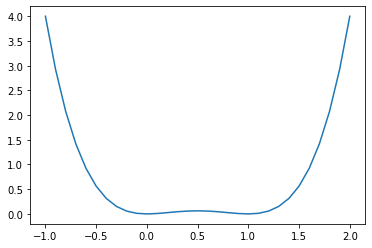

In [11]:
xs = tf.range(-1,2.1,0.1)
ys = constraint_loss_fn(xs)
xs, ys = xs.numpy(), ys.numpy()
plt.plot(xs, ys)

## Optimization loss
Loss to make sure that the output is equal to 1.0

In [12]:
@tf.function
def loss_fn(candidate, output):
    optimization_loss = tf.math.squared_difference(output, 1.0)
    constraint_loss = constraint_loss_fn(candidate)
    constraint_loss = tf.reduce_sum(constraint_loss)
    return optimization_loss + constraint_loss

candidate = tf.Variable([-1, 1, 2], dtype=tf.float32)
output = tf.Variable(0.5, dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
    z = loss_fn(candidate, output)
    
print(z)
print(tape.gradient(z,output))
print(tape.gradient(z,candidate))

tf.Tensor(8.25, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor([-12.   0.  12.], shape=(3,), dtype=float32)


## Training/Optimization

In [13]:
candidate = tf.Variable([0, 1, 0], dtype=tf.float32)
problem_encoding = tf.Variable([
   [0, 0, 1], 
   [0, 1, 0], 
   [1, 0, 0], 
], dtype=tf.float32)

opt = tf.keras.optimizers.Adam(learning_rate=3e-4)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        z = circuit_forward_pass(candidate, problem_encoding)
        loss = loss_fn(candidate, z)
    grads = tape.gradient(loss, candidate)
    opt.apply_gradients(zip([grads], [candidate]))
    return loss

for i in range(10000):
    loss = train_step()
    if i % 1000 == 0:
        tf.print(i, loss, candidate)

0 1 [0.000300008513 0.9997 0.000300008513]
1000 0.372614384 [0.202071369 0.809448719 0.202071369]
2000 0.302438021 [0.317299336 0.773605466 0.317299306]
3000 0.217134744 [0.467763871 0.900396705 0.467763722]
4000 0.101519562 [0.686918437 1.02080131 0.686917782]
5000 0.012053174 [0.915573061 1.00370216 0.915572584]
6000 2.50427984e-05 [0.996464252 1.00000632 0.996464193]
7000 2.62632721e-10 [0.999989033 1.00000441 0.999989033]
8000 2.00159576e-11 [0.999997437 1.00000262 0.999997437]
9000 7.20489597e-12 [0.99999845 1.00000155 0.99999845]


## Result
$X_1 = 1.0$, $X_2 = 1.0$ and $X_3 = 1.0$ is a valid candidate which we can verify manually.

In [14]:
print(tf.round(candidate))
z = circuit_forward_pass(tf.round(candidate), problem_encoding)
print(z)

tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
